## Investigation of Healthcare Facilities Availability in the Toronto Neighborhoods using FourSquare APIs.

### 1) Research Problem and Background 

Access to healthcare is a very important comodity, requiring equal consideration to make when especially when one is planning to move to a new or another neighborheed or buy property in a new neighborhood. This consideration is even more inportant to people who have limited mobility such as the elderly and people with disability.

The importance of having Knowledge about the availability of healthcare in the neighborhood is not limited to people planning to move or buy property. It is also very important to people living in those neighborhoods to know how to and where to access healthcare within their neighborhood. 
Some people travel to work in other neighborhoods where they spend a majority of their day and it would be helpful if people know what type of services are available in those neighborhoods. 

Making available, information that people faced with making these considerations can use to be able to make informed decision about what neighborhood to choose can be of vital importance. The data product, created from this study will help to fill in this void.

### 2) Description of the Data used in this Study

A data set that contains the Toronto neighborhoods names and the geographic coordinates of each neighbourhood is needed for this study. The geographic coordinates of each neighborhood is needed in order to be able to link with the FourSquare database and pull data on healthcare facilities in the neighborhood. Fortunately, part of this data is publicly available on the Wikipedia website. The complementary part of the data can also be freely scraped from the internet using a free geocoder Python package.

The last and most important dataset needed for this study is the Toronto healthcare facilities dataset. FourSquare allows a free scraping of this dataset from their database. This data can be extracted by category of the facility and by neighborhood in which the facility belongs. This data contains information about the facility name, address of the facility and the the category of the facility. The data also contains other information that is not needed for this study.

This data will help answer the following questions:

a) What type of Healthcare facilities are available in each neighborhood?

b) How many of each type of healthcare facilities are available in each neighborhood?

c) What neighborhoods are similar in terms of the availability of healthcare facilities?

d) What are the most common healthcare facilities in each neighborhood?

### 3) Research Questions in this Study:

a) What type of Healthcare facilities are available in each neighborhood?

b) How many of each type of healthcare facilities are available in each neighborhood?

c) What neighborhoods are similar in terms of the availability of healthcare facilities?

d) What are the top most common facilities in each neighborhood?

### 4) Research Methodology

#### 4.1) Data Collection

Data collection was done in three steps:
###### A) Toronto Boroughs and Neighborhoods
Data on the Toronto Boroughs and Neighborhoods was scrapped from Wikipedia website (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M), using the Pandas Python Library. This dataset has three columns. The first column of this dataset is the first three digits of the postal code of each neighborhood. The second column is the name of the Borough and the last column is the name of the neighborhood. This dataset does not have the geography coordinates of the neighbourhoods.

###### B) Toronto Neighborhoods geography coordinates
The data on the geography coordinates of the neighborhoods can be scrapped using the Google Maps Geocoding API. However, Google does charge a fee. A Geocoder Python package which is free of charge can be used to scrape the data. However, this pakage is not very stable.I downloaded a prepared csv version of the data from the data from the following website: http://cocl.us/Geospatial_data. This data has three columns: the postal code column which contains the first three digits of the Toronto Neighborhoods postal codes, a lattitude column and a longitude column.

###### C) Neighborhoods Health Facilities 
I used FourSquare APIs to scrape data on all types of healthcare facilities which are located within a radius of 3,000 meters around each neighborhood. I limited the number of healthcare facilities within this area, in each neighborhood to 3,000 facilities. This does not mean that a neighbourhood can be expected to have up to 3,000 healthcare facilities.

#### 4.2) Data Cleaning and preparation

The Toronto neighborhood data scrapped from Wikipedia website contains rows for neighborhoods that have not yet been assigned. These rows were excluded from all analyses. In this dataset, the first three digits of the postal code could belong to more than one neighborhood. In this case, the neighborhoods with the same first three didgit postal code were merged together to create one row in the dataset. The final dataset had only unique postal codes in the data.

The geography coordinates dataset was already cleaned and ready for use. The only change made was renaming of the columns to facilitate analysis.

The neighborhoods health facilities data, scrapped from FourSquare comes in the form of a Jason data file format. This data file contains more than enough information. The is cleaned to keep only information about each facility's name, category, geography coordinates and the address.  

#### 4.3) Data analysis 

Simple descriptive methods were used to calculate descriptive statistics such as the number of health care categories in each neighborhood, the number of healthcare facilities in each category, the top 10 most common healthcare facilities in each neighborhood.

The k-means clustering algorithm was used to segment and cluster neighborhoods, based on their similarity according to the type of healthcare facilities available in the neighborhoods.

The Folium map visualization Python libbrary was used to visualize the clustered neighborhoods in an interactive map that allows user to zoom in or out to explore the neighborhoods.

#### Data Collection, Cleaning and preparation

##### Import needed Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


##### A) Toronto Boroughs and Neighborhoods 
The Toronto neighborhood data can be scraped from the wikipedia website

In [3]:
df=pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M',header=0)[0]
# Rename some colunms
df.rename(columns={"Postcode": "PostalCode", "Neighbourhood": "Neighborhood"},inplace=True)

# Create filter to use in filtering and removing unwanted rows
filter1=df['Borough']=="Not assigned"
filter2=df['Neighborhood']=="Not assigned"

In [4]:
# Delete unwanted rows
df2=df[~filter1].copy().reset_index(drop=True)

# Replace the "Not assigned" in the column: Neighbourhood, with NaN
df2.Neighborhood.replace("Not assigned",np.nan,inplace=True)

In [5]:
# Replace the missings in the column: Neighbourhood with values in the column: Borough
df2['Neighborhood'].fillna(df2['Borough'],inplace=True)
df2.tail()

,PostalCode,Borough,Neighborhood
205,M8Z,Etobicoke,Kingsway Park South West
206,M8Z,Etobicoke,Mimico NW
207,M8Z,Etobicoke,The Queensway West
208,M8Z,Etobicoke,Royal York South West
209,M8Z,Etobicoke,South of Bloor


In [6]:
# Group the postalCode and concatenate all Neighbourhoods in the same PostalCode to form one row
# for each postal code
df3= df2.groupby('PostalCode')['Neighborhood'].apply(', '.join).reset_index()

In [7]:
# Add back the Borough column to the data
df2_sorted=df2.sort_values("PostalCode").copy()
# Remove duplicates
df_NoDuplicates=df2_sorted.drop_duplicates(subset ="PostalCode").copy()
df_NoDuplicates.drop('Neighborhood',axis=1,inplace=True)
df4=df3.merge(df_NoDuplicates, how = "left", on = "PostalCode")
df5=df4.loc[:,['PostalCode','Borough','Neighborhood']]

##### B) Toronto Neighborhoods geography coordinates
This data file is readily available at the following website: http://cocl.us/Geospatial_data/Geospatial_Coordinates.csv

In [41]:
# load the geospacial coordinates dataset
df_longlat=pd.read_csv("http://cocl.us/Geospatial_data/Geospatial_Coordinates.csv")
df_longlat.rename(columns={"Postal Code": "PostalCode"},inplace=True)
df_longlat.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [14]:
# Use a Join add the longitudes and lattitudes to the Ontario neighborhoods data
neighborhoods=df5.merge(df_longlat, how = "left", on = "PostalCode")
print("The Ontario neighborhoods dataset now has {} rows and {} columns.".format(
    neighborhoods.shape[0],neighborhoods.shape[1]))
neighborhoods.head()

The Ontario neighborhoods dataset now has 103 rows and 5 columns.


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [15]:
# Subset data to neighborhoods where Borough contain Toronto
#df_Toronto=neighborhoods[neighborhoods['Borough'].str.contains("Toronto")].reset_index().copy()

df_Toronto=neighborhoods.copy()

In [16]:
df_Toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


##### C) Neighborhoods Health Facilities
Use the FourSquare API credentials to scrape the Toronto neighborhood healthcare facilities data

In [18]:
CLIENT_ID = 'GSXYNS5UUSFJGCDIZBHFSOTVRDBQMNO2SULNHRYWFSDAHF1T' # your Foursquare ID
CLIENT_SECRET = 'C45HSTDNR0TNLV0GO0JMUWSYJWOVNN02VURKEOJAUABYZCYT' # your Foursquare Secret
VERSION = '20200202' # Foursquare API version
search_query = 'Medical Center'
categoryId = '4bf58dd8d48988d104941735'

In [37]:
LIMIT = 5000 # limit of number of venues returned by Foursquare API
radius = 5000 # define radius
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat, 
            lng, 
            VERSION, 
            search_query, 
            radius, 
            LIMIT, 
            categoryId)
            
        # make the GET request
        results = requests.get(url).json()['response']['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'],
            v['location']['lng'],
            v['location']['formattedAddress'][0],
            v['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Address',
                  'Venue Category']
    
    return(nearby_venues)

In [38]:
# type your answer here

Toronto_venues = getNearbyVenues(names=df_Toronto['Neighborhood'],
                                   latitudes=df_Toronto['Latitude'],
                                   longitudes=df_Toronto['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

In [39]:
print(Toronto_venues.shape)
Toronto_venues.head()

(4817, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Address,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Milner Medical Centre,43.799632,-79.197910,Ontario,Doctor's Office
1,"Rouge, Malvern",43.806686,-79.194353,Medical Centre Family Physicians,43.800811,-79.199986,1152 Morningside Avenue,Medical Center
2,"Rouge, Malvern",43.806686,-79.194353,Appletree Medical Centre,43.769355,-79.184662,4-4218 LAWRENCE AVE E,Medical Center
3,"Rouge, Malvern",43.806686,-79.194353,Medical Building,43.790951,-79.250743,1711 McCowen Road,Medical Center
4,"Rouge, Malvern",43.806686,-79.194353,Malvern Medical Centre,43.808561,-79.219776,1333 Neilson Rd. (at Tapscott),Doctor's Office


In [40]:
# Save a copy of the data
Toronto_venues.to_csv('Toronto_venues.csv')

##### Data Analysis and Results

a) What type of Healthcare facilities are available in each neighborhood?

In [65]:
toronto_healthcare_facility_categoris=Toronto_venues['Venue Category'].value_counts().reset_index()
toronto_healthcare_facility_categoris.columns=['Healthcare Facility Category','Count of Facility']
toronto_healthcare_facility_categoris

,Healthcare Facility Category,Count of Facility
0,Doctor's Office,2245
1,Medical Center,2046
2,Medical Lab,169
3,Dentist's Office,154
4,Hospital,47
5,Physical Therapist,43
6,Chiropractor,19
7,Spa,14
8,Mental Health Office,10
9,Alternative Healer,10


There are 20 categories of healthcare facilities in the data. This analysis will focus on the top 10 categories.

In [98]:
# Count the number of healthcare facilities by neighborhood.

Facility_counts= pd.crosstab(Toronto_venues.Neighborhood, 
                             Toronto_venues['Venue Category'], 
                             margins=False).reset_index()
del Facility_counts.columns.name
print('This dataset has {} rows and {} columns'.format(
    Facility_counts.shape[0],Facility_counts.shape[1]))


This dataset has 103 rows and 21 columns


In [99]:
Top10_categories=Facility_counts.loc[:,['Neighborhood','Hospital',"Doctor's Office",'Medical Center',
                                        'Medical Lab',"Dentist's Office",'Physical Therapist',
                                        'Chiropractor','Spa','Mental Health Office',
                                        'Alternative Healer']]

#### Top 10 Toronto neighborhoods that havethe highest number of hospital
What are the top 10 Toronto neighborhoods that have the highest number of Hospitals?

In [108]:
Top10_categories.sort_values("Hospital", axis = 0, ascending = False, 
                 inplace = True, na_position ='last')

neighborhood_with_hospitals=Top10_categories.head(10).copy().reset_index(drop=True)
neighborhood_with_hospitals=neighborhood_with_hospitals.loc[:,['Neighborhood',"Hospital"]]
neighborhood_with_hospitals

,Neighborhood,Hospital
0,Queen's Park,3
1,Central Bay Street,3
2,"Ryerson, Garden District",3
3,"Adelaide, King, Richmond",2
4,"Humber Bay, King's Mill Park, Kingsway Park So...",2
5,"Humber Bay Shores, Mimico South, New Toronto",2
6,Church and Wellesley,2
7,"Harbord, University of Toronto",2
8,"Chinatown, Grange Park, Kensington Market",2
9,"Bathurst Manor, Downsview North, Wilson Heights",1


Queen's Park, Ryerson, Garden District and Central Bay Street neighborhoods have the highest number of hospitals, with each having three hospitals.

#### Top 10 Toronto neighborhoods that have the highest number of Doctor's Offices
What are the top 10 Toronto neighborhoods that have the highest number of Doctor's Offices?

In [107]:
Top10_categories.sort_values("Doctor's Office", axis = 0, ascending = False, 
                 inplace = True, na_position ='last')

neighborhood_with_Dr_Offices=Top10_categories.head(10).copy().reset_index(drop=True)
neighborhood_with_Dr_Offices=neighborhood_with_Dr_Offices.loc[:,['Neighborhood',"Doctor's Office"]]
neighborhood_with_Dr_Offices

,Neighborhood,Doctor's Office
0,"Bathurst Manor, Downsview North, Wilson Heights",28
1,"Bedford Park, Lawrence Manor East",28
2,Willowdale South,28
3,"Flemingdon Park, Don Mills South",28
4,"Emery, Humberlea",28
5,"Newtonbrook, Willowdale",27
6,"Silver Hills, York Mills",27
7,Downsview Central,27
8,"Lawrence Heights, Lawrence Manor",27
9,"Maryvale, Wexford",27


As shown in the table above, five neighbourhoods have the highest number of doctor's offices with each of them having 28 doctor's offices

#### Top 10 Toronto neighborhoods that have the highest number of Medical Laboratories
What are the top 10 Toronto neighborhoods that have the highest number of medical laboratories?

In [110]:
Top10_categories.sort_values("Medical Lab", axis = 0, ascending = False, 
                 inplace = True, na_position ='last')

neighborhood_with_labs=Top10_categories.head(10).copy().reset_index(drop=True)
neighborhood_with_labs=neighborhood_with_labs.loc[:,['Neighborhood',"Medical Lab"]]
neighborhood_with_labs

,Neighborhood,Medical Lab
0,Central Bay Street,6
1,"Adelaide, King, Richmond",5
2,"First Canadian Place, Underground city",5
3,"Commerce Court, Victoria Hotel",5
4,Stn A PO Boxes 25 The Esplanade,5
5,"Chinatown, Grange Park, Kensington Market",5
6,"Design Exchange, Toronto Dominion Centre",5
7,Harbourfront,4
8,"Harbord, University of Toronto",4
9,"Ryerson, Garden District",4


The Central Bay Street neighborhood has the highest number of medical laboratory (6 in number), followed by five other neighborhoods with 5 medical laboratories each and three other neighborhoods with 4 medical laboratories each.

##### Top 10 Toronto neighborhoods that have the highest number of Dentist's Office
What are the top 10 Toronto neighborhoods that have the highest number of Dentist's Office?

In [111]:
Top10_categories.sort_values("Dentist's Office", axis = 0, ascending = False, 
                 inplace = True, na_position ='last')

neighborhood_with_dentist=Top10_categories.head(10).copy().reset_index(drop=True)
neighborhood_with_dentist=neighborhood_with_dentist.loc[:,['Neighborhood',"Dentist's Office"]]
neighborhood_with_dentist

,Neighborhood,Dentist's Office
0,"Bathurst Manor, Downsview North, Wilson Heights",6
1,"Newtonbrook, Willowdale",5
2,York Mills West,5
3,Willowdale South,5
4,Bayview Village,5
5,Willowdale West,5
6,"The Beaches West, India Bazaar",4
7,Hillcrest Village,4
8,"Northwood Park, York University",4
9,"Agincourt North, L'Amoreaux East, Milliken, St...",4


#### What are the top 5 most common facilities in each neighborhood?

In [117]:
# one hot encoding
toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

In [118]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [120]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
              venue  freq
0    Medical Center  0.50
1   Doctor's Office  0.34
2       Medical Lab  0.10
3          Hospital  0.04
4  Dentist's Office  0.02


----Agincourt----
              venue  freq
0   Doctor's Office  0.46
1    Medical Center  0.42
2  Dentist's Office  0.06
3      Chiropractor  0.02
4      Optical Shop  0.02


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
              venue  freq
0    Medical Center  0.48
1   Doctor's Office  0.38
2  Dentist's Office  0.08
3     Acupuncturist  0.02
4      Chiropractor  0.02


----Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown----
              venue  freq
0    Medical Center  0.43
1   Doctor's Office  0.43
2  Dentist's Office  0.07
3    Massage Studio  0.04
4      Chiropractor  0.04


----Alderwood, Long Branch----
                venue  freq
0      Medical Center  0.52
1     Doctor's Office  0.36
2         Medical L


----East Birchmount Park, Ionview, Kennedy Park----
              venue  freq
0    Medical Center  0.48
1   Doctor's Office  0.42
2  Dentist's Office  0.06
3      Rehab Center  0.02
4       Medical Lab  0.02


----East Toronto----
                venue  freq
0     Doctor's Office  0.48
1      Medical Center  0.42
2         Medical Lab  0.04
3                 Spa  0.02
4  Physical Therapist  0.02


----Emery, Humberlea----
              venue  freq
0   Doctor's Office  0.74
1    Medical Center  0.18
2    Massage Studio  0.03
3      Chiropractor  0.03
4  Dentist's Office  0.03


----Fairview, Henry Farm, Oriole----
              venue  freq
0   Doctor's Office  0.50
1    Medical Center  0.38
2  Dentist's Office  0.06
3       Medical Lab  0.06
4     Acupuncturist  0.00


----First Canadian Place, Underground city----
              venue  freq
0    Medical Center  0.50
1   Doctor's Office  0.38
2       Medical Lab  0.10
3  Dentist's Office  0.02
4     Acupuncturist  0.00


----Flemingdon 

#### What neighborhoods are similar in terms of the top 10 most common healthcare facilities in the neighbourhood?

In [121]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [137]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

#neighborhoods_venues_sorted.head(3)

In [124]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 3, 2, 3, 0, 1, 1, 1, 0, 3])

In [125]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_Toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() 

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1,Doctor's Office,Medical Center,Optical Shop,Medical Lab,Dentist's Office,Spa,Eye Doctor,Alternative Healer,Bank,Chiropractor
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,3,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
3,M1G,Scarborough,Woburn,43.770992,-79.216917,3,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,3,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room


#### Create an interactive map to visualize the clusters of neighborhoods that are similar in terms of the availabilty of the top 10 most common healthcare facilities

In [127]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [128]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

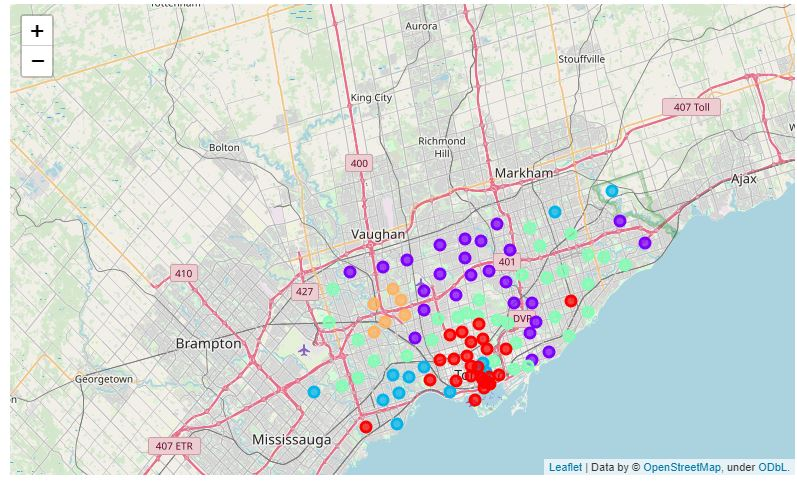

#### Which neighborhoods are grouped together in cluster 1, the cluster with the red colour on the map?

In [138]:
# Cluster 1: colour=Red
Cluster1=toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(
    range(5, toronto_merged.shape[1]))]]
print("There are {} neighborhoods in cluster 1.".format(Cluster1.shape[0]))
Cluster1

There are 27 neighborhoods in cluster 1.


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,"East Birchmount Park, Ionview, Kennedy Park",0,Medical Center,Doctor's Office,Dentist's Office,Medical Lab,Rehab Center,Spa,Eye Doctor,Alternative Healer,Bank,Chiropractor
41,"The Danforth West, Riverdale",0,Medical Center,Doctor's Office,Medical Lab,Spa,Physical Therapist,Eye Doctor,Alternative Healer,Bank,Chiropractor,Dentist's Office
47,Davisville,0,Medical Center,Doctor's Office,Physical Therapist,Medical Lab,Dentist's Office,Spa,Eye Doctor,Alternative Healer,Bank,Chiropractor
48,"Moore Park, Summerhill East",0,Medical Center,Doctor's Office,Physical Therapist,Medical Lab,Gym,Spa,Eye Doctor,Alternative Healer,Bank,Chiropractor
49,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",0,Medical Center,Doctor's Office,Physical Therapist,Medical Lab,Gym,Spa,Eye Doctor,Alternative Healer,Bank,Chiropractor
50,Rosedale,0,Medical Center,Doctor's Office,Medical Lab,Physical Therapist,Spa,Eye Doctor,Alternative Healer,Bank,Chiropractor,Dentist's Office
53,Harbourfront,0,Medical Center,Doctor's Office,Medical Lab,Physical Therapist,Dentist's Office,Spa,Eye Doctor,Alternative Healer,Bank,Chiropractor
55,St. James Town,0,Medical Center,Doctor's Office,Medical Lab,Dentist's Office,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
56,Berczy Park,0,Medical Center,Doctor's Office,Medical Lab,Dentist's Office,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
58,"Adelaide, King, Richmond",0,Medical Center,Doctor's Office,Medical Lab,Hospital,Dentist's Office,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room


#### Which neighborhoods are grouped together in cluster 2, the cluster with the purple colour on the map?¶

In [139]:
# Cluster 2: colour=Purple
Cluster2=toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(
    range(5, toronto_merged.shape[1]))]]
print("There are {} neighborhoods in cluster 2.".format(Cluster2.shape[0]))
Cluster2

There are 25 neighborhoods in cluster 2.


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Rouge, Malvern",1,Doctor's Office,Medical Center,Optical Shop,Medical Lab,Dentist's Office,Spa,Eye Doctor,Alternative Healer,Bank,Chiropractor
1,"Highland Creek, Rouge Hill, Port Union",1,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
17,Hillcrest Village,1,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
18,"Fairview, Henry Farm, Oriole",1,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
19,Bayview Village,1,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Acupuncturist,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
20,"Silver Hills, York Mills",1,Doctor's Office,Medical Center,Medical Lab,Dentist's Office,Maternity Clinic,Spa,Eye Doctor,Alternative Healer,Bank,Chiropractor
21,"Newtonbrook, Willowdale",1,Doctor's Office,Medical Center,Dentist's Office,Hospital,Acupuncturist,Mental Health Office,Medical Lab,Optical Shop,Maternity Clinic,Massage Studio
22,Willowdale South,1,Doctor's Office,Medical Center,Dentist's Office,Acupuncturist,Medical Lab,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
23,York Mills West,1,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Maternity Clinic,Spa,Eye Doctor,Alternative Healer,Bank,Chiropractor
24,Willowdale West,1,Doctor's Office,Medical Center,Dentist's Office,Hospital,Acupuncturist,Mental Health Office,Medical Lab,Optical Shop,Maternity Clinic,Massage Studio


#### Which neighborhoods are grouped together in cluster 3, the cluster with the Blue colour on the map?

In [143]:
# Cluster 3: colour=Blue
Cluster3=toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(
    range(5, toronto_merged.shape[1]))]]
print("There are {} neighborhoods in cluster 3.".format(Cluster3.shape[0]))
Cluster3

There are 13 neighborhoods in cluster 3.


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,"Agincourt North, L'Amoreaux East, Milliken, St...",2,Medical Center,Doctor's Office,Dentist's Office,Acupuncturist,Optical Shop,Chiropractor,Gym,Alternative Healer,Bank,Emergency Room
16,Upper Rouge,2,Doctor's Office,Medical Center,Acupuncturist,Optical Shop,Chiropractor,Medical Lab,Dentist's Office,Eye Doctor,Alternative Healer,Bank
52,Church and Wellesley,2,Medical Center,Doctor's Office,Medical Lab,Hospital,Physical Therapist,Dentist's Office,Eye Doctor,Alternative Healer,Bank,Chiropractor
54,"Ryerson, Garden District",2,Medical Center,Doctor's Office,Medical Lab,Hospital,Dentist's Office,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
57,Central Bay Street,2,Medical Center,Doctor's Office,Medical Lab,Hospital,Dentist's Office,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
78,"Brockton, Exhibition Place, Parkdale Village",2,Medical Center,Doctor's Office,Physical Therapist,Medical Lab,Hospital,Pharmacy,Mental Health Office,Emergency Room,Alternative Healer,Bank
82,"High Park, The Junction South",2,Medical Center,Doctor's Office,Physical Therapist,Hospital,Pharmacy,Alternative Healer,Mental Health Office,Medical Lab,Dentist's Office,Emergency Room
84,"Runnymede, Swansea",2,Medical Center,Doctor's Office,Physical Therapist,Dentist's Office,Hospital,Pharmacy,Alternative Healer,Mental Health Office,Medical Lab,Emergency Room
86,Canada Post Gateway Processing Centre,2,Medical Center,Doctor's Office,Bank,Eye Doctor,Physical Therapist,Chiropractor,Medical Lab,Dentist's Office,Emergency Room,Spa
88,"Humber Bay Shores, Mimico South, New Toronto",2,Medical Center,Doctor's Office,Hospital,Alternative Healer,Medical Lab,Physical Therapist,Emergency Room,Eye Doctor,Bank,Chiropractor


#### Which neighborhoods are grouped together in cluster 4, the cluster with the Green colour on the map?

In [144]:
# Cluster 4: colour=Green
Cluster4=toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(
    range(5, toronto_merged.shape[1]))]]
print("There are {} neighborhoods in cluster 4.".format(Cluster4.shape[0]))
Cluster4

There are 32 neighborhoods in cluster 4.


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Guildwood, Morningside, West Hill",3,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
3,Woburn,3,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
4,Cedarbrae,3,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
5,Scarborough Village,3,Doctor's Office,Medical Center,Dentist's Office,Rehab Center,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
7,"Clairlea, Golden Mile, Oakridge",3,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Spa,Rehab Center,Eye Doctor,Alternative Healer,Bank,Chiropractor
8,"Cliffcrest, Cliffside, Scarborough Village West",3,Doctor's Office,Medical Center,Dentist's Office,Rehab Center,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
9,"Birch Cliff, Cliffside West",3,Doctor's Office,Medical Center,Dentist's Office,Spa,Medical Lab,Rehab Center,Eye Doctor,Alternative Healer,Bank,Chiropractor
10,"Dorset Park, Scarborough Town Centre, Wexford ...",3,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Rehab Center,Spa,Eye Doctor,Alternative Healer,Bank,Chiropractor
11,"Maryvale, Wexford",3,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Rehab Center,Spa,Eye Doctor,Alternative Healer,Bank,Chiropractor
12,Agincourt,3,Doctor's Office,Medical Center,Dentist's Office,Optical Shop,Chiropractor,Medical Lab,Spa,Eye Doctor,Alternative Healer,Bank


#### Which neighborhoods are grouped together in cluster 5, the cluster with the Orange colour on the map?

In [145]:
# Cluster 4: colour=Orange
Cluster5=toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(
    range(5, toronto_merged.shape[1]))]]
print("There are {} neighborhoods in cluster 5.".format(Cluster5.shape[0]))
Cluster5

There are 6 neighborhoods in cluster 5.


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,North York,4,Doctor's Office,Medical Center,Hospital,Chiropractor,Dentist's Office,Massage Studio,Gym,Alternative Healer,Bank,Emergency Room
32,North York,4,Doctor's Office,Medical Center,Hospital,Chiropractor,Dentist's Office,Gym,Alternative Healer,Bank,Emergency Room,Eye Doctor
79,North York,4,Doctor's Office,Medical Center,Dentist's Office,Hospital,Chiropractor,Gym,Alternative Healer,Bank,Emergency Room,Eye Doctor
97,North York,4,Doctor's Office,Medical Center,Chiropractor,Dentist's Office,Massage Studio,Spa,Gym,Alternative Healer,Bank,Emergency Room
98,York,4,Doctor's Office,Medical Center,Chiropractor,Dentist's Office,Spa,Gym,Alternative Healer,Bank,Emergency Room,Eye Doctor
99,Etobicoke,4,Doctor's Office,Medical Center,Chiropractor,Dentist's Office,Medical Lab,Spa,Gym,Alternative Healer,Bank,Emergency Room
